<a href="https://colab.research.google.com/github/wilsonkw97/WhatToEat/blob/main/Restaurant_Recommendation_Engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **A Restaurant Recommendation Engine using Collaborative Filtering**

Use case of UCI Machine Learning dataset by trying out Collaborative Filtering to recommend people places to eat based on their preferences.

Link to data repository: https://www.kaggle.com/uciml/restaurant-data-with-consumer-ratings

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install stop_words

In [ ]:
import numpy as np 
import pandas as pd

In [ ]:
rating_df = pd.read_csv("/content/drive/MyDrive/data/rating_final.csv")

In [ ]:
rating_df.head()

,userID,placeID,rating,food_rating,service_rating
0,U1077,135085,2,2,2
1,U1077,135038,2,2,1
2,U1077,132825,2,2,2
3,U1077,135060,1,2,2
4,U1068,135104,1,1,2


In [ ]:
# view the range of ratings available in the data
rating_df.rating.value_counts()

2    486
1    421
0    254
Name: rating, dtype: int64

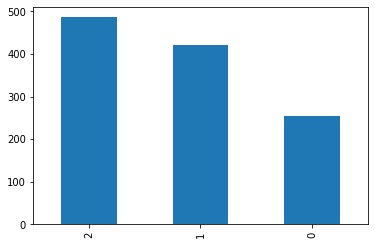

In [ ]:
import matplotlib.pyplot as plt
rating_df.rating.value_counts().plot(kind='bar')
plt.show()

In [ ]:
# checking data type of each column
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1161 entries, 0 to 1160
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userID          1161 non-null   object
 1   placeID         1161 non-null   int64 
 2   rating          1161 non-null   int64 
 3   food_rating     1161 non-null   int64 
 4   service_rating  1161 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 45.5+ KB


In [ ]:
# checking if we need to do any missing values imputation
rating_df.isnull().sum()

userID            0
placeID           0
rating            0
food_rating       0
service_rating    0
dtype: int64

In [ ]:
!pip install surprise

In [ ]:
# preparing the data to be used in the Singular Vector Decomposition method
from surprise import Reader, Dataset
reader = Reader(rating_scale = (0, 2))
ratingdata = Dataset.load_from_df(rating_df[['userID','placeID','rating']], reader)

**Training the model to build up the recommendation system**

In [ ]:
# Taken from the documentation https://surprise.readthedocs.io/en/stable/getting_started.html#train-test-split-py
from surprise.model_selection import KFold
from surprise import SVD, accuracy

# define a cross-validation iterator
kf = KFold(n_splits=5)

algo = SVD()

for trainset, testset in kf.split(ratingdata):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)

RMSE: 0.7200
RMSE: 0.6611
RMSE: 0.7227
RMSE: 0.7051
RMSE: 0.6511


In [ ]:
# Adapted from https://surprise.readthedocs.io/en/stable/FAQ.html
import random
from surprise.model_selection import GridSearchCV

raw_ratings = ratingdata.raw_ratings
# shuffle ratings if you want
random.shuffle(raw_ratings)

# A = 80% of the data, B = 20% of the data
threshold = int(.8 * len(raw_ratings))
A_raw_ratings = raw_ratings[:threshold]
B_raw_ratings = raw_ratings[threshold:]

ratingdata.raw_ratings = A_raw_ratings  # ratingdata is now the set A

param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(ratingdata)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.7337582214135363
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.6}


In [ ]:
# We can now use the algorithm that yields the best rmse:
algo = gs.best_estimator['rmse']

for trainset, testset in kf.split(ratingdata):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)

RMSE: 0.7125
RMSE: 0.7355
RMSE: 0.7410
RMSE: 0.7310
RMSE: 0.6922


In [ ]:
testset[0]

('U1092', 132723, 1.0)

In [ ]:
recommendations = [pred for pred in predictions if pred[0] == 'U1045']

In [ ]:
recommendations

[Prediction(uid='U1045', iid=135051, r_ui=2.0, est=1.3795845238579956, details={'was_impossible': False}),
 Prediction(uid='U1045', iid=135064, r_ui=0.0, est=1.211651679003422, details={'was_impossible': False})]

In [ ]:
from collections import defaultdict

def get_all_predictions(predictions):
    
    # First map the predictions to each user.
    top_n = defaultdict(list)    
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    # Then sort the predictions for each user
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
    return top_n

all_pred = get_all_predictions(predictions)

In [ ]:
all_pred

defaultdict(list,
            {'U1003': [(132755, 1.2528260869461272)],
             'U1004': [(135062, 1.2641213939614815),
              (135032, 1.2362366600193968)],
             'U1005': [(135041, 1.2576252965452386),
              (135050, 1.1702874326220778)],
             'U1007': [(135057, 1.0872791887111457),
              (132572, 1.0345159682512415)],
             'U1010': [(135042, 1.190230600991474),
              (135058, 1.1425679687421886),
              (135064, 1.132698932822473)],
             'U1012': [(134983, 1.028890412562654)],
             'U1014': [(135082, 1.2244309745925197),
              (132830, 1.1896100214020302)],
             'U1015': [(132845, 1.0857608115148507)],
             'U1016': [(135042, 1.4158462480673355)],
             'U1017': [(134975, 1.0741044367672306)],
             'U1018': [(135066, 1.1894237506853322),
              (135108, 1.1534666170606998),
              (135069, 1.1433107542095737)],
             'U1019': [(135079, 1.06451

In [ ]:
new_all_pred=dict(filter(lambda elem: len(elem[1]) != 1, all_pred.items()))

In [ ]:
n = 3
for uid, user_ratings in new_all_pred.items():
    user_ratings.sort(key=lambda x: x[1], reverse=True)
    new_all_pred[uid] = user_ratings[:n]
    
tmp = pd.DataFrame.from_dict(new_all_pred)
tmp_transpose = tmp.transpose()

In [ ]:
tmp_transpose

,0,1
U1060,"(132733, 1.2487400847192796)","(132740, 1.1415686000969056)"
U1037,"(135070, 1.2444801290275425)","(132847, 1.2132792866142292)"
U1007,"(135057, 1.0872791887111457)","(132572, 1.0345159682512415)"
U1045,"(135051, 1.3795845238579956)","(135064, 1.211651679003422)"
U1053,"(132754, 1.431145388834091)","(135053, 1.3530533826999422)"
U1049,"(135051, 1.0461358226314001)","(135041, 0.9660403878985544)"
U1137,"(132834, 1.3010121512694997)","(132951, 1.2810555684816376)"
U1062,"(135062, 1.092380547062368)","(135085, 1.088222590169234)"
U1121,"(135019, 1.193873488119213)","(132767, 1.1848507593098416)"
U1135,"(135045, 1.0290445229541558)","(135041, 0.9679102131759019)"


In [ ]:
restaurant_info = pd.read_csv('/content/drive/MyDrive/data/geoplaces2.csv', usecols = ['placeID','name'], low_memory = True)

In [ ]:
restaurant_info

,placeID,name
0,134999,Kiku Cuernavaca
1,132825,puesto de tacos
2,135106,El Rinc�n de San Francisco
3,132667,little pizza Emilio Portes Gil
4,132613,carnitas_mata
...,...,...
125,132866,Chaires
126,135072,Sushi Itto
127,135109,Paniroles
128,135019,Restaurant Bar Coty y Pablo


pandas.core.series.Series

In [ ]:
def get_predictions(user_id):
    results = tmp_transpose.loc[user_id]
    return results

user_id = 'U1073'
results = get_predictions(user_id)
results

0    (135062, 0.8942349189229344)
1    (132834, 0.6171712376341516)
Name: U1073, dtype: object

In [ ]:
def findRestaurantInfo(id):
    return print(restaurant_info[restaurant_info['placeID']==id])

In [ ]:
# Get restaurants suggested
for item in results:
    findRestaurantInfo(item[0])

     placeID                           name
113   135062  Restaurante El Cielo Potosino
    placeID                 name
80   132834  Gorditas Doa Gloria


**Item Based Filtering**

Not too sure how to work it out to allow recommendations based on restaurant name. Suppose to use distance?

In [ ]:
restaurant_name = input()

little pizza Emilio Portes Gil


In [ ]:
def findRestaurantInfo2(name):
    return restaurant_info[restaurant_info['name']==name]['placeID']

visitedrestaurantID = findRestaurantInfo2(restaurant_name)

In [ ]:
from collections import defaultdict

def get_all_predictions(predictions):
    
    # First map the predictions to each places.
    top_n = defaultdict(list)    
    for uid, iid, true_r, est, _ in predictions:
        top_n[iid].append((uid, est))
    # Then sort the predictions for each places
    for iid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
    return top_n

all_pred = get_all_predictions(predictions)

In [ ]:
all_pred

defaultdict(list,
            {132561: [('U1026', 1.2588006393384588)],
             132572: [('U1007', 1.0345159682512415),
              ('U1091', 0.9853525285146275)],
             132594: [('U1123', 1.1045020834234347)],
             132608: [('U1050', 1.0180243972715206)],
             132609: [('U1070', 1.1519503298199962)],
             132654: [('U1026', 1.1811291673988367),
              ('U1065', 1.178545649998284)],
             132667: [('U1063', 1.1780743917038023)],
             132717: [('U1023', 1.1705386161541684)],
             132723: [('U1095', 1.4827144350798773),
              ('U1083', 1.3413963974163683),
              ('U1092', 1.1062268736978926)],
             132732: [('U1043', 0.9669985367924446)],
             132733: [('U1060', 1.2487400847192796),
              ('U1103', 1.0365238917258235)],
             132740: [('U1060', 1.1415686000969056)],
             132754: [('U1053', 1.431145388834091)],
             132755: [('U1003', 1.2528260869461272)],
   

In [ ]:
new_all_pred=dict(filter(lambda elem: len(elem[1]) != 1, all_pred.items()))

In [ ]:
n = 2
for iid, user_ratings in new_all_pred.items():
    user_ratings.sort(key=lambda x: x[1], reverse=True)
    new_all_pred[iid] = user_ratings[:n]
    
tmp = pd.DataFrame.from_dict(new_all_pred)
tmp_transpose = tmp.transpose()

In [ ]:
tmp_transpose

,0,1
132723,"(U1095, 1.4827144350798773)","(U1083, 1.3413963974163683)"
132733,"(U1060, 1.2487400847192796)","(U1103, 1.0365238917258235)"
135071,"(U1025, 1.324943810569689)","(U1037, 1.1871235894017258)"
135001,"(U1133, 1.2705252927447692)","(U1118, 1.1064005459707622)"
132862,"(U1029, 1.315232153843547)","(U1106, 1.1330066232989036)"
132572,"(U1007, 1.0345159682512415)","(U1091, 0.9853525285146275)"
135051,"(U1045, 1.3795845238579956)","(U1049, 1.0461358226314001)"
135060,"(U1053, 1.3012397187527311)","(U1135, 0.9518962507730637)"
135019,"(U1121, 1.193873488119213)","(U1093, 1.1063418662204225)"
135057,"(U1088, 1.4246213163580002)","(U1007, 1.0872791887111457)"


In [ ]:
def get_predictions(place_id):
    results = tmp_transpose.loc[str(place_id)]
    return results

for values in visitedrestaurantID.values:
  results = get_predictions(values)

results

KeyError: ignored